In [1]:
#@title Check GPU
!nvidia-smi

Mon Nov 14 23:42:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Installs
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     |████████████████████████████████| 5.5 MB 43.8 MB/s 
     |████████████████████████████████| 441 kB 86.5 MB/s 
     |████████████████████████████████| 118 kB 93.0 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 212 kB 90.3 MB/s 
     |████████████████████████████████| 115 kB 91.4 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 163 kB 93.7 MB/s 
     |████████████████████████████████| 127 kB 94.5 MB/s 
     |████████████████████████████████| 138 kB 88.9 MB/s 
     |████████████████████████████████| 357 kB 39.7 MB/s 
     |████████████████████████████████| 379 kB 92.9 MB/s 
     |████████████████████████████████| 93 kB 2.1 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 2.3 MB 77.5 MB/s 
     |████████████████████████████████| 115 kB 87.0 MB/s 
     |████████████████████████████████| 7.6 MB 84.1 MB/s 
     |████████████████

In [3]:
#@title Imports
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

from google.colab import drive
drive.mount('/content/drive')

nltk.download("punkt")

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# from datasets import load_dataset

In [5]:
#@title Pretrained Pegasus on CNN/Dailymail
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

In [6]:
#@title Functions for Batching and Calculating Metrics
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### [amazon_us_reviews-Videos Dataset](https://https://huggingface.co/datasets/amazon_us_reviews/viewer/Video_v1_00/train)

In [7]:
#@title Load Dataset
dataset_amazon = load_dataset("amazon_us_reviews", 'Video_v1_00')

Generating train split:   0%|          | 0/380604 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Video_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#@title Look at Data
split_lengths = [len(dataset_amazon[split])for split in dataset_amazon]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_amazon['train'].column_names}")
print("\nReview Body:")

print(dataset_amazon["train"][0]["review_body"])

print("\nHeadline:")

print(dataset_amazon["train"][0]["review_headline"])

Split lengths: [380604]
Features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

Review Body:
Fast shipping. Pleasure to deal with. Would recommend. A+++. Thanks!

Headline:
Very satisfied!!


### Evaluating PEGASUS on Amazon Reviews

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_amazon['train'][0]['review_body'] )

print(pipe_out)

Your max_length is set to 128, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


[{'summary_text': 'Fast shipping. Pleasure to deal with. A+++. Thanks!<n>Fast shipping. Pleasure to deal with. A+++.<n>Thanks!<n>Fast shipping. Pleasure to deal with. A+++.'}]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_amazon['train'][:10000], rouge_metric, model_pegasus, tokenizer, column_text = 'review_body', column_summary='review_headline', batch_size=8 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


100%|██████████| 1250/1250 [3:57:32<00:00, 11.40s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.002989,0.000083,0.002983,0.002981


In [9]:
model_pegasus.generate()

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 128 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


tensor([[  0, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110,
         107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106,
         110, 107, 106, 110, 107,   1]], device='cuda:0')

### Explore Data and Plot Histogram

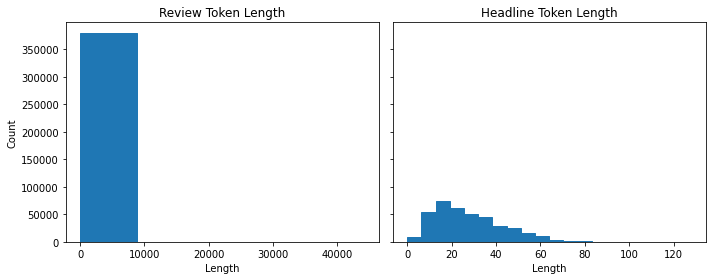

In [ ]:
#@title Review and Headline Length
review_len = [len(s) for s in dataset_amazon['train']['review_body']]

headline_len = [len(s) for s in dataset_amazon['train']['review_headline']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 5, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

Majority of reviews have < 10,000 words, some extend to over 40,000. Let's remove the reviews with length > 10k.

In [ ]:
count = 0
for review in dataset_amazon['train']['review_body']:
  if len(review) > 1024:
    count +=1
print(count)

79372


In [10]:
#@title Create DataFrame
amazon_train_df = pd.DataFrame(dataset_amazon['train'])
print(amazon_train_df.shape)
amazon_train_df.head()

(380604, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,49033728,R1P1G5KZ05H6RD,6302503213,748506413,The Night They Saved Christmas [VHS],Video,5,0,0,0,1,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...,2015-08-31
1,US,17857748,R106N066IUN8ZV,B000059PET,478710180,"Hamlet / Kline, New York Shakespeare Festival ...",Video,5,0,0,0,1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen...",2015-08-31
2,US,25551507,R7WTAA1S5O7D9,0788812807,981002815,Nascar Dual Powered Calculator (Solar & Batter...,Video,4,0,0,0,1,Four Stars,great movie,2015-08-31
3,US,21025041,R32HFMVWLYOYJK,6302509939,333219811,"The Man From U.N.C.L.E, Volume 19: The Brain K...",Video,5,0,0,0,1,Five Stars,i love the martin landau episode,2015-08-31
4,US,40943563,RWT3H6HBVAL6G,B00JENS2BI,538101194,Playboy Video Party Jokes [VHS],Video,3,0,0,0,0,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...,2015-08-31


In [11]:
#@title Keep necessary columns
amazon_train_df = amazon_train_df[['review_headline','review_body']]
print(amazon_train_df.shape)
amazon_train_df.head()

(380604, 2)


,review_headline,review_body
0,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...
1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen..."
2,Four Stars,great movie
3,Five Stars,i love the martin landau episode
4,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...


In [12]:
#@title Filter Reviews with length > 1024
mask = (amazon_train_df['review_body'].str.len() <= 1024) 
amazon_train_df = amazon_train_df.loc[mask]
print(amazon_train_df.shape)
amazon_train_df.head()

(301232, 2)


,review_headline,review_body
0,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...
1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen..."
2,Four Stars,great movie
3,Five Stars,i love the martin landau episode
4,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...


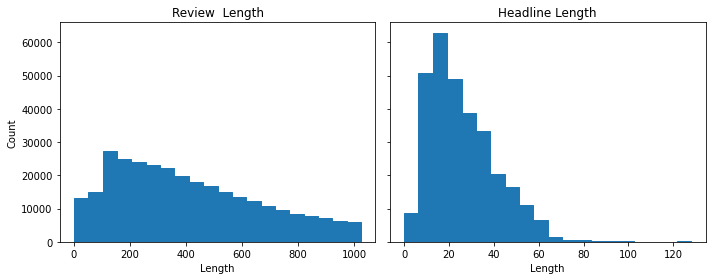

In [ ]:
#@title Review Filtered Length
review_len = [len(s) for s in amazon_train_df['review_body']]

headline_len = [len(s) for s in amazon_train_df['review_headline']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review  Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

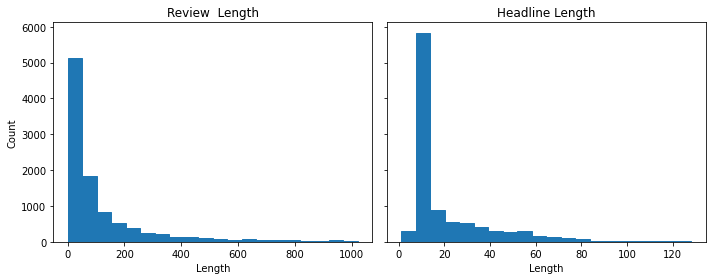

In [ ]:
#@title Review Filtered Length first 10,000 records
review_len = [len(s) for s in amazon_train_df[:10000]['review_body']]

headline_len = [len(s) for s in amazon_train_df[:10000]['review_headline']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review  Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

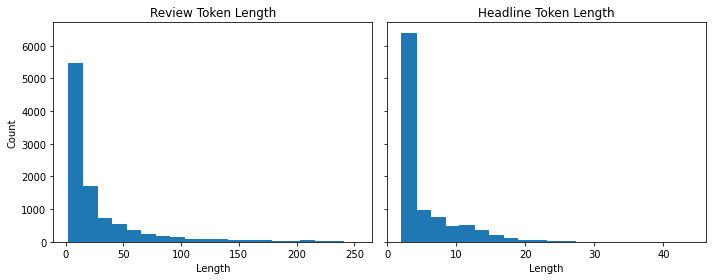

In [ ]:
#@title Review and Headline Token Length of Trimmed Dataset First 10,000 Records

review_token_len = [len(tokenizer.encode(s, max_length=1024, truncation = True)) for s in amazon_train_df[:10000]['review_body']]

headline_token_len = [len(tokenizer.encode(s, max_length = 128, truncation = True)) for s in amazon_train_df[:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

### Split Data Train/Validation/Test

In [13]:
type(dataset_amazon)

datasets.dataset_dict.DatasetDict

In [14]:
import datasets
type(datasets.Dataset.from_dict(amazon_train_df))


datasets.arrow_dataset.Dataset

In [15]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['review_body'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['review_headline'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
  
#Update below code with trimmed dataset name before mapping
amazon_train_dataset = datasets.Dataset.from_dict(amazon_train_df)
dataset_amazon_pt = amazon_train_dataset.map(convert_examples_to_features, batched = True)
# dataset_amazon_pt = amazon_train_df.map(convert_examples_to_features, batched = True)

  0%|          | 0/302 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [16]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [17]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-amazon', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#@title Split PT Dataset
# 70% train, 30% test + validation
train_testvalid = dataset_amazon_pt.train_test_split(test_size=0.3)
# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [20]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 210862
    })
    test: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45185
    })
    valid: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45185
    })
})

In [21]:
train_test_valid_dataset['train']

Dataset({
    features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 210862
})

In [22]:
#@title Split amazon_train_dataset
# 70% train, 30% test + validation
amazon_train_testvalid = amazon_train_dataset.train_test_split(test_size=0.3)
# Split the 20% test + valid in half test, half valid
amazon_test_valid = amazon_train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
amazon_train_test_valid_dataset = datasets.DatasetDict({
    'train': amazon_train_testvalid['train'],
    'test': amazon_test_valid['test'],
    'valid': amazon_test_valid['train']})

In [23]:
amazon_train_test_valid_dataset['train']

Dataset({
    features: ['review_headline', 'review_body'],
    num_rows: 210862
})

### Train Pegasus on Amazon Data

In [ ]:
#@title Create Trainer
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_test_valid_dataset['train'], 
                  eval_dataset=train_test_valid_dataset['valid'])

In [ ]:
#@title Train Model with Amazon Data
trainer.train()

# score = calculate_metric_on_test_ds(
#     train_test_valid_dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'review_body', column_summary= 'review_headline'
# )

# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = [f'pegasus'] )

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 210862
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 13178
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer

Step,Training Loss,Validation Loss
500,4.029900,3.588988
1000,3.370400,3.473976
1500,3.517200,3.420411
2000,3.388700,3.383012
2500,3.477800,3.350254
3000,3.643500,3.331129
3500,3.535900,3.313395
4000,3.349000,3.298621
4500,3.481200,3.283996
5000,3.498700,3.278181


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 45185
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 45185
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `Pegasus

Step,Training Loss,Validation Loss
500,4.029900,3.588988
1000,3.370400,3.473976
1500,3.517200,3.420411
2000,3.388700,3.383012
2500,3.477800,3.350254
3000,3.643500,3.331129
3500,3.535900,3.313395
4000,3.349000,3.298621
4500,3.481200,3.283996
5000,3.498700,3.278181


In [72]:
#@title Save Model
# trainer.save_model('drive/MyDrive/model_weights/pegasus-amazon')

Saving model checkpoint to drive/MyDrive/model_weights/pegasus-amazon
Configuration saved in drive/MyDrive/model_weights/pegasus-amazon/config.json
Model weights saved in drive/MyDrive/model_weights/pegasus-amazon/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/model_weights/pegasus-amazon/tokenizer_config.json
Special tokens file saved in drive/MyDrive/model_weights/pegasus-amazon/special_tokens_map.json


In [ ]:
# !cp -r pegasus-amazon /content/drive/MyDrive/

### Evaluate New Model

In [24]:
#@title Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = 'drive/MyDrive/model_weights/pegasus-amazon'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
trainer = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [25]:
trainer.generate()

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 128 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


tensor([[   0,  114, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358, 7358,
         7358, 7358, 7358, 7358, 7358, 7358, 7358,    1]], device='cuda:0')

In [22]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_amazon['train'][0]['review_body'] )

print(pipe_out)

Your max_length is set to 128, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


[{'summary_text': 'Fast shipping and Pleasure to deal with. Would recommend. A+++. Thanks! Thanks! Fast shipping and Pleasure to deal with. Would recommend. Would recommend. A+++. Thanks!'}]


In [27]:
#@title Determine Rouge Scores of New Model
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    train_test_valid_dataset['test'], rouge_metric, trainer, tokenizer, batch_size = 2, column_text = 'review_body', column_summary= 'review_headline'
)
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 22593/22593 [16:27:12<00:00,  2.62s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.004957,0.000099,0.004926,0.004928


### Generating Highlights

In [93]:

gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

sample_text = amazon_train_test_valid_dataset["test"][0]["review_body"]

reference = amazon_train_test_valid_dataset["test"][0]["review_headline"]

model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to('cpu')

pipe = pipeline("summarization", model=model, tokenizer = tokenizer)

## 
print("Review Body:")
print(sample_text)


print("\nReference Highlight:")
print(reference)


print("\nModel Highlight:")
print(pipe(amazon_train_test_valid_dataset['test'][0]['review_body'], **gen_kwargs)[0]["summary_text"])

Review Body:
I loved this introductory video to yoga.  I once attended a &quot;beginners&quot; yoga class once and left feeling like an unbalanced, unflexible embarrased idiot.  Plus everyone was paying more attention to who was more flexible, etc.  It was a very competitive non relaxing experience.  I loved to hear from the video that not all yoga is &quot;not competitive&quot;.  Wanting to escape that setting I opted for this video and loved it, I knew deep down that yoga was what I was looking for as a release for stress. I slept more deeply than I had in years after my first Yoga for dummies session.  Plus, my back felt great, I cracked almost every joint in the streches.  I am in love with yoga now, thank you so much Sara Ivanhoe!

Reference Highlight:
Yoga rocks....you to sleep and flexibility

Model Highlight:
I loved this introductory video to yoga. I once attended a &quot;beginners&quot; yoga class once and left feeling like an unbalanced, unflexible embarrased idiot. It was a